In [ ]:
import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import keras
import functools
import IPython.display
from io import BytesIO
from google.colab import files
import numpy as np
import pandas as pd

In [ ]:
def show_im(img, title):
    # Убираем нулевую ось, чтобы показать картинку
    img = np.squeeze(img, axis = 0)
    plt.title(title)
    plt.imshow(np.uint8(img))

In [ ]:
n_rows, n_cols = 512, 512
new_size = (n_rows, n_cols)

def prepare_img(image):
  ratio = min(new_size[0]/image.size[0], new_size[1]/image.size[1])
  w = int(image.size[0] * ratio)
  h = int(image.size[1] * ratio)
  image = image.resize((w, h), Image.ANTIALIAS)

  im_array = process_im.img_to_array(image)
  # Нулевая ось для восприятия vgg19
  im_array = np.expand_dims(im_array, axis = 0)
  
  return im_array

In [ ]:
content_name = 'test_4.jpg'
style_name = 'test2.jpg'

In [ ]:
upl = files.upload()
plt.figure(figsize = (10, 10))

content = prepare_img(Image.open(BytesIO(upl[content_name])))
style = prepare_img(Image.open(BytesIO(upl[style_name])))

plt.subplot(1, 2, 1)
show_im(content, 'Content Image')
plt.subplot(1, 2, 2)
show_im(style, 'Style Image')
plt.show()

Saving test_4.jpg to test_4.jpg
Saving test2.jpg to test2.jpg


In [ ]:
def img_preprocess(img_path):
    image = prepare_img(Image.open(BytesIO(upl[img_path])))
    # Преобразование изображения в формат, который воспринимает vgg19
    # RGB -> BGR
    # Меняет степень значения у цветовых компонентов
    # B: 103.939; G: 116,779; R: 123.68
    # (вычитает такие средние значения)
    img = tf.keras.applications.vgg19.preprocess_input(image)
    return img

In [ ]:
# Функция для обратного преобразования BGR -> RGB
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    # Удаление нулевой оси, добавленной ранее
    x = np.squeeze(x, 0)

  # Прибавляем значения, которые отняли ранее
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # Конвертируем BGR -> RGB
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
# Названия слоев, которые будем выделять из сети vgg19
# Для контента используется последний сверточный слой
content_layers = ['block5_conv2']

# Для определения ошибок по стилю
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
                
number_content = len(content_layers)
number_style = len(style_layers)

In [ ]:
def get_model():
    vgg = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')
    vgg.trainable = False

    # Выделяем выходы, которые сообветствуют именам 'block1_conv1' и тд
    content_output = [vgg.get_layer(layer).output for layer in content_layers]
    style_output = [vgg.get_layer(layer).output for layer in style_layers]
    model_output = style_output + content_output

    # модель, которая на входе принимает изображение, а на выходе даёт промежуточные слои для стиля и контента
    return keras.models.Model(vgg.input, model_output)

In [ ]:
# Загрузка сети
# include_top = False - не используем полносвязную нейронную сеть на конце
model = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')
model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
model = get_model()
print(model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
# Вычисляет матрицу Грама для тензора
# Тензор представлен в виде: Nh * Nw * Nc (высота, ширина, каналы)
# Характеризует схожесть признаков между разными каналами
def gram_matrix(tensor):
    channels = int(tensor.shape[-1]) # Nc

    # Преобразования многоканального тензора в 2-мерный
    # Первая размерность - Nh * Nw
    # Вторая размерность - число каналов Nc
    vector = tf.reshape(tensor, [-1, channels])
    n = tf.shape(vector)[0] # Nh * Nw

    # Транспонированную матрицу A умножаем на A
    gram_matrix = tf.matmul(vector, vector, transpose_a = True)
    
    # Полученное значение делим на Nh * Nw
    # Чтобы усреднить
    return gram_matrix/tf.cast(n, tf.float32)

In [ ]:
# Вычисляет ошибки стиля или контента для определенного слоя нейронной сети
# Аргументы - матрица грама для определенного слоя сети и карта стиля/контента формируемого изображения
def get_gram_loss(gram_target, base_feature):
    # Матрица Грама для формируемного изображения
    gram_noise = gram_matrix(base_feature)

    # Вычисление среднего квадрата рассогласования 
    loss = tf.reduce_mean(tf.square(gram_target - gram_noise))
    
    return loss

In [ ]:
# Функция, которая рассчитывает признаки стиля и контента
def get_features(model, content_path, style_path):
    content_img = img_preprocess(content_path)
    style_image = img_preprocess(style_path)

    content_output = model(content_img)
    style_output = model(style_image)

    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]] 
       
    return content_feature, style_feature

In [ ]:
# Функция, которая вычисляет общую ошибку
# loss_weights - содержит 2 параметра style_weight и content_weight
# image - изображение, которое в процессе оптимизации будет обновляться
def compute_loss(model, loss_weights, image, gram_style_features, gram_content_features):
    #Определяют насколько важен стиль/контент в формируемом изображении
    style_weight, content_weight = loss_weights

    # Коллекция значений на каждом сверточном слое, это даст представление контента и стиля
    output = model(image)

    # Величина ошибки
    content_loss = 0
    style_loss = 0

    # Выделение из коллекции карты признаков для стилей
    base_style_features = output[:number_style]
    # Выделение из коллекции карты признаков для контента 
    base_content_features = output[number_style:]

    # a - матрица грама для изначального изображения стиля, в b лежит массив с 1 элементом
    # b - карта признаков стиля, которую получили пропуская формируемое изображение через сеть
    for a, b in zip(gram_style_features, base_style_features):
        # Суммирование квадратов рассогласования
        style_loss += get_gram_loss(a, b[0])

    # То же самое для слоя контента
    # Тк он один, цикл отработает 1 раз
    for a, b in zip(gram_content_features, base_content_features):
        content_loss += get_gram_loss(a, b[0])

    style_loss *= float(style_weight)/float(number_style)
    content_loss *= float(content_weight)/float(number_content)
    
    total_loss = content_loss + style_loss

    # Общие потери + потери по каждой из компонент (стиль и контент)
    return total_loss, style_loss, content_loss

In [ ]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**dictionary)

    #all_loss содержит 3 параметра style_loss, content_loss, all_loss
    total_loss = all_loss[0]

    return tape.gradient(total_loss, dictionary['image']), all_loss

In [ ]:
# content_weight - насколько важен контент на формируемом изображении
def run_style_transfer(content_path, style_path, epochs = 100, content_weight = 1e2, style_weight = 1e-2):

    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    #Особенности стиля и контента от изначальных картинок
    content_feature, style_feature = get_features(model, content_path, style_path)

    style_gram_matrix = [gram_matrix(feature) for feature in style_feature]
    content_gram_matrix = [gram_matrix(feature) for feature in content_feature]

    # Начальное изображение
    base_image = img_preprocess(content_path)
    # Преобразование в то, что понимает TF
    base_image = tf.Variable(base_image, dtype = tf.float32)

    # Оптимизатор для алгоритма градиентного спуска
    optimizer = tf.keras.optimizers.Adam(learning_rate = 5, beta_1 = 0.99, epsilon = 1e-1)

    # Лучшая ошибка и соответствующее ей изображение
    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)

    dictionary = {'model': model,
                  'loss_weights': loss_weights,
                  'image': base_image,
                  'gram_style_features': style_gram_matrix,
                  'gram_content_features': content_gram_matrix}

    # BGR -> RGB
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    # Алгоритм градиентного спуска 
    for i in range(epochs):
        # Пропускает формируемое изображение через сеть
        grad, all_loss = compute_grads(dictionary)
        total_loss, style_loss, content_loss = all_loss

        # Приминяем вычисленный градиент к пикселям изображения
        optimizer.apply_gradients([(grad, base_image)])

        # Ограничиваем пиксель мин и макс значениями
        clipped = tf.clip_by_value(base_image, min_vals, max_vals)
        base_image.assign(clipped)

        # Поиск минимальной ошибки
        if total_loss < best_loss:
            best_loss = total_loss
            best_img = deprocess_img(base_image.numpy())

        if i % 5 == 0:
            plot_img = base_image.numpy()
            plot_img = deprocess_img(plot_img)

            IPython.display.clear_output(wait = True)
            IPython.display.display_png(Image.fromarray(plot_img))

            print('Epoch: {}'.format(i))
            print('Total loss: {:.4e}, '
                  'Style loss: {:.4e}, '
                  'Content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))

    IPython.display.clear_output(wait = True)


    return best_img, best_loss

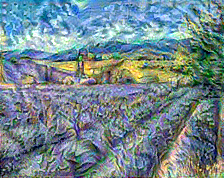

Epoch: 45
Total loss: 1.9934e+07, Style loss: 1.1783e+07, Content loss: 8.1509e+06, 


In [ ]:
best, best_loss = run_style_transfer(content_name, style_name, epochs = 50)

In [ ]:
def show_result():
  plt.figure(figsize = (15, 15))

  plt.subplot(1, 3, 3)
  plt.imshow(best)
  plt.title('Style transfer Image')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(1, 3, 1)
  show_im(content, 'Content Image')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(1, 3, 2)
  show_im(style, 'Style Image')
  plt.xticks([])
  plt.yticks([])

  plt.show()

In [ ]:
show_result()

In [ ]:
show_result()

In [ ]:
show_result()

In [ ]:
show_result()

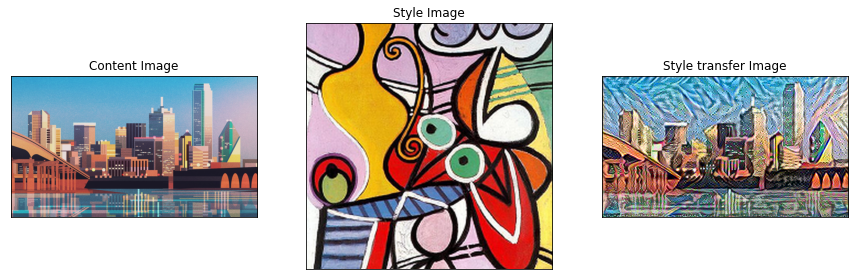

In [ ]:
show_result()

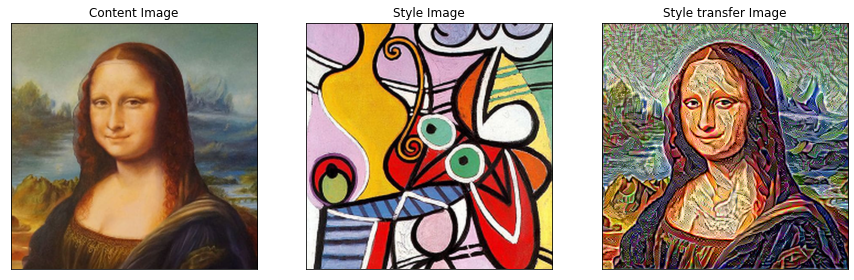

In [ ]:
show_result()

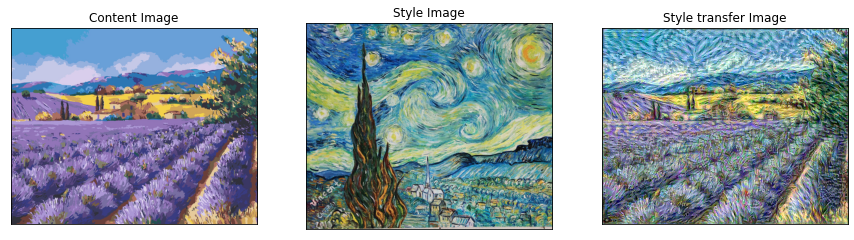

In [ ]:
show_result()

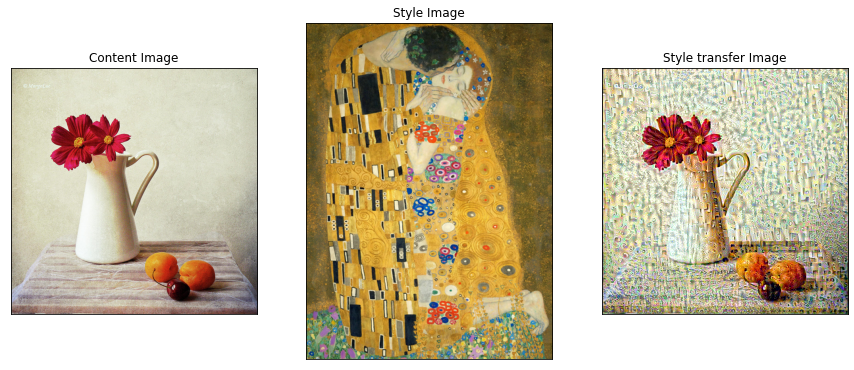

In [ ]:
show_result()

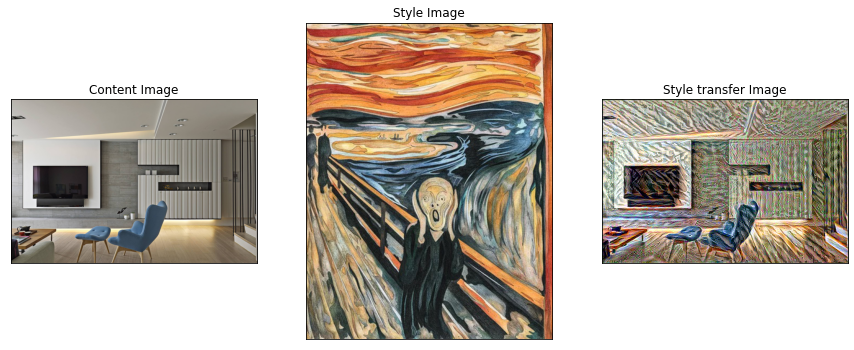

In [ ]:
show_result()

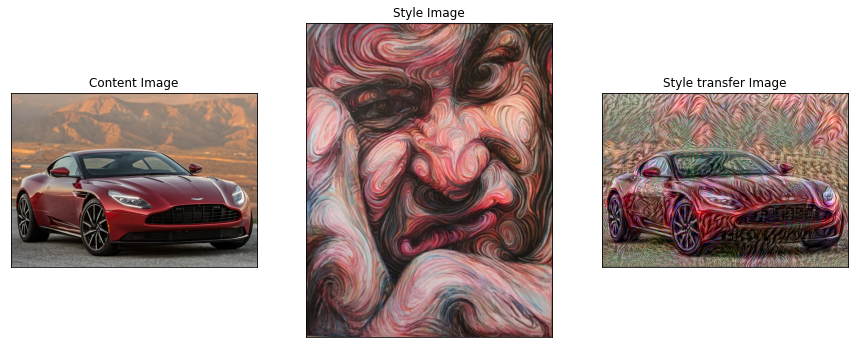

In [ ]:
show_result()

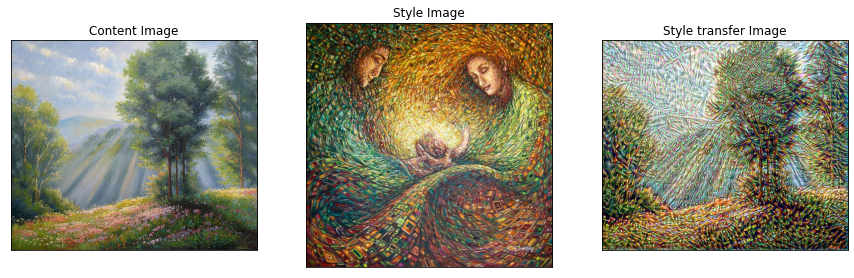

In [ ]:
show_result()

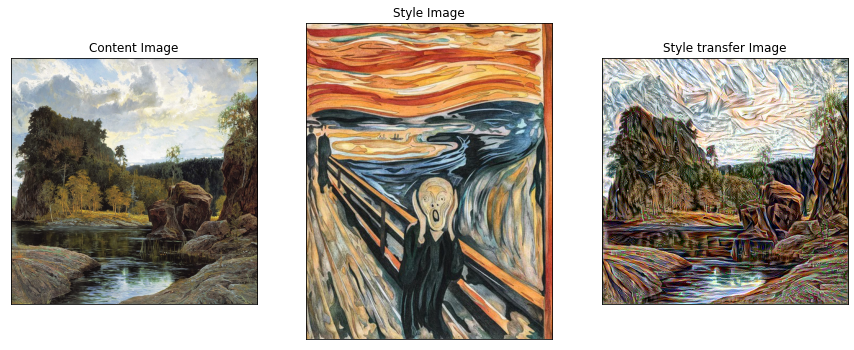

In [ ]:
show_result()